## Trabalho 1
#### Fazer ajuste geométrico de uma curva de luz 'na mão'. 

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import curve_fit

 - Carregando DataFrame, passando seus valores pra variável lightcurve (lc). Pegando as colunas de interesse e nomeando de acordo.

In [2]:
df = pd.read_csv('curve03.dat', delim_whitespace=True)
lc = pd.DataFrame(data = df.values, #columns = ['Time', 'LightCurve']
                 )

In [3]:
tempo=lc[4] #x
fluxo=lc[9] #y
incerteza=lc[10]

 - Plot inicial a partir de valores chutados, mas próximos do real

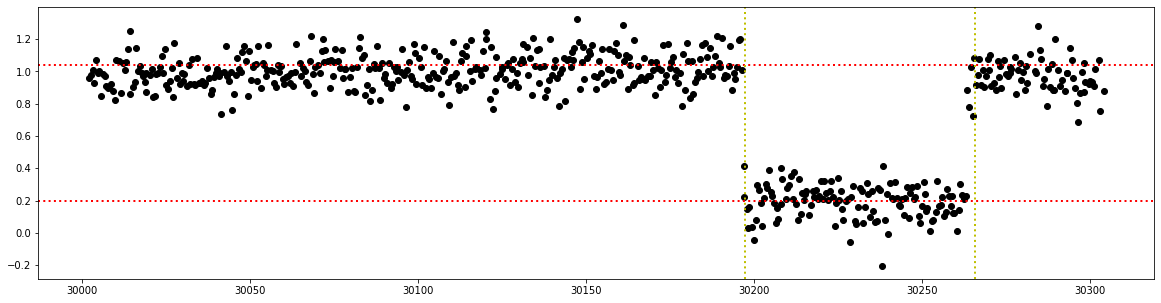

In [4]:
plt.figure(figsize = [20,5])

plt.plot(tempo,fluxo, 'ko')
#Valores chutados
plt.axhline(1.04, color='r', linestyle='dotted', linewidth=2) # brilho estrela
plt.axhline(0.2, color='r', linestyle='dotted', linewidth=2) # brilho durante ocultação
plt.axvline(30197.5, color='y', linestyle='dotted', linewidth=2) # tempo de ingresso
plt.axvline(30266, color='y', linestyle='dotted', linewidth=2) # tempo de egresso

plt.show()

 - Criação da função que, dado os parâmetros chutados, fita uma curva aproximada. Junto dela é criado a função de residuo quadrado e, ainda mais adiante, chi quadrado para medir a qualidade desse ajuste.

In [5]:
def function(x, valory1,valory2,valorx1,valorx2):
    '''
    Docstring: a função pega os valores de cada ponto x e dita um y condicional. Caso o valor seja maior ou menor do que
    os valores ditados nos parametros, ele entrará como um valor especifico, parecido c o de uma caixa.
    '''
    y = valory1*np.ones(len(x)) #podia usar np.repeat(b0,len(x))
    #Mascara
    y[(x>valorx1)*(x<valorx2)] = valory2
    return y


def residuo_quadrado(data, modelo):
    return np.sum((data - modelo)**2)

/home/laidler/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


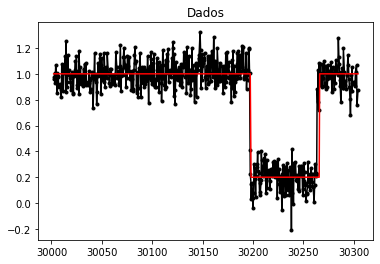

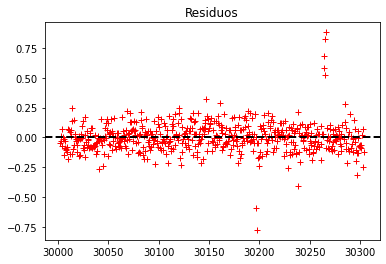

Soma dos quadrados dos residuos: 9.421857774069531


In [6]:
y_modelo = function(tempo,1,0.2,30197.5,30266)

plt.title('Dados')
plt.plot(tempo, fluxo, 'k.-')
plt.plot(tempo, y_modelo, 'r-')
plt.show()

plt.title('Residuos')
plt.plot(tempo, fluxo - y_modelo, 'r+')
plt.axhline(0, color='k', ls='--', lw=2)
plt.show()

print('Soma dos quadrados dos residuos:', residuo_quadrado(data=fluxo, modelo=y_modelo))

 - $\chi^{2}_{pdf}$ (por grau de liberdade)

In [10]:
chi_2 = residuo_quadrado(data=fluxo, modelo=y_modelo)/(np.std(fluxo - y_modelo)**2)
print('Chi_2pdf: ', chi_2/(len(tempo) - 4)) #4 graus de liberdade, são 4 parametros que ajustamos.
print('Desvio Padrão: ', np.std(fluxo - y_modelo #sigma = desvio padrão -> medida de dispersão em torno da média

Chi_2pdf:  1.0075223500770494
Desvio Padrão:  0.12557800545239559


    -Com o chi_2 encontrado, sabemos que o ajuste está decente

 - No entanto, o resultado foi chutado. Gostaria de fazer uma forma que não dependesse da (extrema) sorte do usuário. Tentarei, de início, rodar outros testes e ver se encontro valores melhores. Se não for possível, farei pelo método do curvefit.

In [24]:
from tqdm import tqdm

teste_x1, teste_x2 = np.meshgrid(np.linspace(30100, 30247, 150), np.linspace(30250, 30290, 150))

chi2 = 9999999*np.ones(teste_x1.shape)

for i in tqdm(range(teste_x1.shape[0])):
    for j in range(teste_x1.shape[1]):
        y_modelo = function(tempo,1,0.2, teste_x1[i, j], teste_x2[i, j])
        chi2[i, j] = residuo_quadrado(data=fluxo, modelo=y_modelo)/(0.1255**2)

  0%|          | 0/150 [00:00<?, ?it/s]/home/laidler/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
100%|██████████| 150/150 [00:48<00:00,  3.08it/s]


In [31]:
print(chi2.min())
print(np.where(chi2 == chi2.min()))
print('x1 =', teste_x1[49,50]) #Tempo de ingresso
print('x2 =', teste_x2[98, 98]) #Tempo de egresso
print('x1_chute = ', 30197.50)
print('x2_chute = ', 30266.00)

389.1230626036749
(array([49, 50]), array([98, 98]))
x1 = 30149.328859060402
x2 = 30276.308724832215
x1_chute =  30197.5
x2_chute =  30266.0


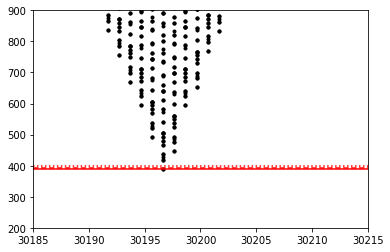

In [28]:
plt.plot(teste_x1, chi2, 'k.')

plt.axhline(chi2.min()+1, color='r', ls='-')
plt.axhline(chi2.min()+4, color='r', ls='--')
plt.axhline(chi2.min()+9, color='r', ls=':')

plt.ylim(200, 900)
plt.xlim(30185, 30215)

plt.show()

In [30]:
y_modelo = function(tempo,1,0.2,30149.32,30276.30)
chi_2 = residuo_quadrado(data=fluxo, modelo=y_modelo)/(np.std(fluxo - y_modelo)**2)
print('Chi_2pdf: ', chi_2/(len(tempo) - 4)) 
print('Desvio Padrão: ', np.std(fluxo - y_modelo))

Chi_2pdf:  1.2284787419046548
Desvio Padrão:  0.3443654555315536


 - O chute deve ter sido de extrema sorte >.<

##### Abaixo tentei usar curve_fit, mas antes simplifiquei a função inicial partindo do principio que os valores de y1 e y2 são os mesmos que utilizei anteriormente. Afinal, o que me interessa é o tempo de ingresso e egresso, e o chute está adequado. No entanto, creio que o tipo de função que preciso pra uma curva de luz não funciona bem com curve_fit.

In [40]:
def function(x,valorx1,valorx2):
    '''
    Docstring: a função pega os valores de cada ponto x e dita um y condicional. Caso o valor seja maior ou menor do que
    os valores ditados nos parametros, ele entrará como um valor especifico, parecido c o de uma caixa.
    '''
    y = 1*np.ones(len(x)) #podia usar np.repeat(b0,len(x))
    #Mascara
    y[(x>valorx1)*(x<valorx2)] = 0.2
    return y

from scipy.optimize import curve_fit
parameters, covariance = curve_fit(function, tempo, fluxo, p0=[30197, 30270])
error = incerteza
print('Parametros: \n', parameters, '\n')
print('Covariancia: \n', covariance)

Parametros: 
 [30197. 30270.] 

Covariancia: 
 [[inf inf]
 [inf inf]]


##### Abaixo tentei ver se conseguia utilizar o curve_fit caso passasse pelo filtro de Savitzky-Golay. Não funcionou. Além disso, o filtro não é útil pra esse problema já que se deixa levar pelo ruído da observação, embora ainda 'suavize' o ajuste. 

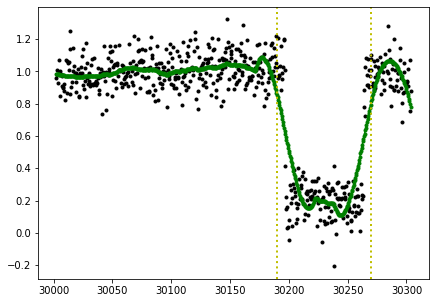

In [52]:
import scipy.signal as signal
y_sg = signal.savgol_filter(fluxo, window_length=101, polyorder=2)
x_sg = signal.savgol_filter(tempo, window_length=101, polyorder=2)

plt.figure(figsize=[7, 5])

plt.plot(tempo, fluxo, 'k.')
plt.plot(x_sg, y_sg, 'g.-')
plt.axvline(30190, color='y', linestyle='dotted', linewidth=2) # tempo de ingresso seguindo o filtro
plt.axvline(30270, color='y', linestyle='dotted', linewidth=2) # tempo de egresso seguindo o filtro


plt.show()

In [53]:
print('x1 =', 30190) #Tempo de ingresso
print('x2 =', 30270) #Tempo de egresso

x1 = 30190
x2 = 30270


In [55]:
y_modelo = function(tempo,30190,30270)
chi_2 = residuo_quadrado(data=fluxo, modelo=y_modelo)/(np.std(fluxo - y_modelo)**2)
print('Chi_2pdf: ', chi_2/(len(tempo) - 4)) 
print('Desvio Padrão: ', np.std(fluxo - y_modelo))

Chi_2pdf:  1.0406397648235992
Desvio Padrão:  0.19428937131243376


/home/laidler/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


 - Um valor pra chi_2 bem decente também.

 ## Conclusão:
 - Os resultados mais próximos do procurado foram :
 
        x1_chute =  30197.5
        x2_chute =  30266.0
        ___________________________
        Chi_2pdf:  1.0075223500770494
        Desvio Padrão:  0.12557800545239559
        ____________________________
    O modelo que eu procuro é apenas o geométrico, ou seja, neste formato de 'caixa', que considera apenas o efeito físico da ocultação. Seguindo esse modelo, que parte do chute incrivelmente certeiro, consegui uma boa medida para o tempo de ingresso e egresso dessa curva. 
    Comparando com os valores encontrados na minha IC, com o software SORA, temos:
    
        x1_chute =  30197.5
        x2_chute =  30266.0
    
        x1_IC = 30194.247
        x2_IC = 30261.150
    
    É esperado certa diferença visto que não foi considerado outros efeitos da observação, como o efeito de Fresnell que afeta os raios que batem na borda do anteparo (corpo ocultador).